In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pickle
import json

from shapely import wkt

from joblib import Parallel, delayed
import multiprocessing

import scipy.stats as stats
from scipy.spatial import distance
from sklearn.preprocessing import OrdinalEncoder
from easydict import EasyDict as edict
from tqdm import tqdm

from scipy.stats import wasserstein_distance

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import nltk

import powerlaw

In [2]:
# import sys
# sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils.utils import setup_seed, load_config

In [3]:
import matplotlib.pyplot as plt
import matplotlib

np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)


colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]


In [4]:
def _apply_parallel(ls, func, n=-1, **kwargs):
    """parallel apply for spending up."""
    length = len(ls)
    cpunum = multiprocessing.cpu_count()
    if length < cpunum:
        spnum = length
    if n < 0:
        spnum = cpunum + n + 1
    else:
        spnum = n or 1

    return Parallel(n_jobs=n, verbose=0)(delayed(func)(seq, **kwargs) for seq in ls)

def loglikelihood_ratio(loglikelihoods1, loglikelihoods2,normalized_ratio=False):
    from numpy import sqrt
    from scipy.special import erfc

    n = float(len(loglikelihoods1))

    if n==0:
        R = 0
        p = 1
        return R, p
    from numpy import asarray
    loglikelihoods1 = asarray(loglikelihoods1)
    loglikelihoods2 = asarray(loglikelihoods2)

    #Clean for extreme values, if any
    from numpy import inf, log
    from sys import float_info
    min_val = log(10**float_info.min_10_exp)
    loglikelihoods1[loglikelihoods1==-inf] = min_val
    loglikelihoods2[loglikelihoods2==-inf] = min_val

    R = sum(loglikelihoods1-loglikelihoods2)

    from numpy import mean
    mean_diff = mean(loglikelihoods1)-mean(loglikelihoods2)
    variance = sum(( (loglikelihoods1-loglikelihoods2) - mean_diff)**2)/n

    p = erfc( abs(R) / sqrt(2*n*variance))

    return R, p

def getAIC(fit, empr):
    aics = []

    aics.append(-2*np.sum(fit.truncated_power_law.loglikelihoods(empr))+4)
    aics.append(-2*np.sum(fit.power_law.loglikelihoods(empr))+2)
    aics.append(-2*np.sum(fit.lognormal.loglikelihoods(empr))+4)
    
    aics = aics-np.min(aics)
    
    down = np.sum([np.exp(-aic/2) for aic in aics])    
        
    res = {}
    res['truncated_power_law'] = np.exp(-aics[0]/2)/down
    res['power_law'] = np.exp(-aics[1]/2)/down
    res['lognormal'] = np.exp(-aics[2]/2)/down

    return res

# Read 

## Read sequences

In [5]:
file_dir = [    
    # ".\\data\\validation\\na_multi_0_layer6_14_200_1_200.json",
    # ".\\data\\validation\\na_layer6_14_200_1_200.json", # no time
    
    # ".\\data\\validation\\na_layer6_linear_long_14_250_1_200.json",
    # ".\\data\\validation\\na_layer6_linear_long_run2_14_250_1_200.json",

    # ".\\data\\validation\\na_layer6_large_14_200_1_200.json",
    # ".\\data\\validation\\na_layer6_linear_14_200_1_200_seed101.json",
    # ".\\data\\validation\\na_layer6_linear_14_200_1_200_seed102.json", 
    # ".\\data\\validation\\na_layer6_linear_14_200_1_200_seed103.json", 
    
    # ".\\data\\validation\\na_layer6_linear_relu_14_250_1_200_seed101.json",
    ".\\data\\validation\\na_layer6_linear_relu_14_250_1_200_seed102.json",
    # ".\\data\\validation\\na_layer6_linear_relu_14_250_1_200_seed103.json",
    # ".\\data\\validation\\na_layer6_linear_relu_14_250_1_200_seed104.json",
    # ".\\data\\validation\\na_layer6_linear_relu_14_250_1_200_seed105.json",

    # ".\\data\\validation\\na_layer6_linear_relu_smallLR_14_250_1_200.json",

    # ".\\data\\validation\\ablation\\base_200_101.json",
    # ".\\data\\validation\\ablation\\base_200_102.json",
    
    # ".\\data\\validation\\ablation\\base_20_101.json",
    # ".\\data\\validation\\ablation\\base_20_102.json",
    # ".\\data\\validation\\ablation\\base_ctx_20_103.json",

    # ".\\data\\validation\\ablation\\layer2\\duration_ctx_20_102.json",
    # ".\\data\\validation\\ablation\\layer2\\mode_ctx_20_102.json",

    # ".\\data\\validation\\ablation\\layer2\\mode_ctx_200_20_102.json",

    # ".\\data\\validation\\ablation\\layer4\\mode_duration_95_20_101.json",
    # ".\\data\\validation\\ablation\\layer4\\mode_duration_100_20_101.json",
    # ".\\data\\validation\\ablation\\layer4\\mode_duration_110_20_101.json",
    # ".\\data\\validation\\ablation\\layer4\\mode_duration_120_20_101.json",
    # ".\\data\\validation\\ablation\\layer4\\mode_duration_130_20_101.json",

    # ".\\data\\validation\\ablation\\layer6\\duration_20_100.json",
    # ".\\data\\validation\\ablation\\layer6\\duration_20_101.json",
    # ".\\data\\validation\\ablation\\layer6\\duration_20_102.json",
    # ".\\data\\validation\\ablation\\layer6\\duration_20_103.json",
    
    # ".\\data\\validation\\ablation\\layer4\\mode_ctx_80_20_101.json",
    # ".\\data\\validation\\ablation\\layer4\\mode_ctx_110_100_101.json",
    # ".\\data\\validation\\ablation\\layer4\\mode_ctx_120_100_101.json",
    # ".\\data\\validation\\ablation\\layer4\\mode_ctx_130_100_101.json",
    # ".\\data\\validation\\ablation\\layer4\\mode_ctx_150_20_101.json",

    # ".\\data\\validation\\ablation\\layer2\\mode_ctx_200_20_102.json",

    # ".\\data\\validation\\ablation\\layer6\\small_mode_ctx_lr4_seed101_200_100_101.json",
    # ".\\data\\validation\\ablation\\layer6\\small_mode_ctx_lr4_seed102_200_100_101.json",
    # ".\\data\\validation\\ablation\\layer6\\small_mode_ctx_lr4_seed110_200_100_101.json",
    ".\\data\\validation\\ablation\\layer6\\tiny_mode_ctx_lr4_200_100_101.json",    
    
    # ".\\data\\validation\\ablation\\base_ctx_200_101.json",
    # ".\\data\\validation\\ablation\\base_ctx_20_101.json",
    # ".\\data\\validation\\ablation\\base_ctx_102.json",
    # ".\\data\\validation\\ablation\\base_ctx_103.json",

    # ".\\data\\validation\\ablation\\mode_ctx_50_20_102.json",
    # ".\\data\\validation\\ablation\\mode_ctx_100_20_102.json",
    # ".\\data\\validation\\ablation\\mode_ctx_150_20_102.json",
    # ".\\data\\validation\\ablation\\mode_ctx_170_20_102.json",
    
    
    # ".\\data\\validation\\ablation\\layer6\\duration_ctx_20_102.json",
    # ".\\data\\validation\\ablation\\mode_ctx_180_20_102.json",
    # ".\\data\\validation\\ablation\\mode_duration_200_20_102.json",
    
]

predict_ls = []
true_ls = []
src_ls = []

for i, file in enumerate(file_dir):
    predict_curr = []
    with open(file, "r") as f_reader:
        for row in f_reader:
            content = json.loads(row)

            if i == 0:
                src_ls.append((np.array(content["source"])))
    
                target_arr = np.array(content["target"])
                try:
                    target_arr = target_arr[:np.where(target_arr == 0)[0][0]]
                except IndexError:
                    target_arr = target_arr
                true_ls.append(target_arr)

            if len(content["recover"]) >= 50:
                predict_curr.append(np.array(content["recover"][:50]).squeeze())
            else:
                print(len(content["recover"]))
    predict_ls.append(predict_curr)


In [6]:
len(predict_ls), len(predict_ls[0]), len(true_ls), len(src_ls)

(2, 36285, 36285, 36285)

In [7]:
np.mean([len(seq) for seq in src_ls]), np.mean([len(seq) for seq in true_ls])\
, np.max([len(seq) for seq in true_ls]), np.min([len(seq) for seq in true_ls])

(138.37412153782554, 47.75587708419457, 50, 2)

In [8]:
diff_file_name = [name.split("\\")[-1].split(".")[0] for name in file_dir]
# diff_file_name = ["Diffusion (Ours)"]
# diff_file_name = ["Base", "Base + xy + POI"]
diff_file_name 

['na_layer6_linear_relu_14_250_1_200_seed102', 'tiny_mode_ctx_lr4_200_100_101']

In [9]:
clean_predict_ls = []
for ls in predict_ls:
    clean_data = []
    for x in ls:
        clean_data.append(np.array([28741 if item>28741 else item for item in x]))
    clean_predict_ls.append(clean_data)

clean_true = []
for x in true_ls:
    clean_true.append(np.array([28741 if item>28741 else item for item in x]))
    
# 14882 -> 14976 (28743 -> 28800)

In [10]:
for i in range(len(predict_ls)):
    print(np.max([np.max(x) for x in predict_ls[i]]), np.max([np.max(x) for x in clean_predict_ls[i]]))

print(np.max([np.max(x) for x in true_ls]), np.max([np.max(x) for x in clean_true]))

28738 28738
28739 28739
28741 28741


In [11]:
predict_ls = clean_predict_ls
true_ls = clean_true

## Read all locations

In [12]:
# initialization
config = load_config("./config/diff.yml")
config = edict(config)

In [13]:
all_locs = pd.read_csv(os.path.join("data", "s2_loc_visited_level10_14.csv"), index_col="id")
all_locs["geometry"] = all_locs["geometry"].apply(wkt.loads)
all_locs = gpd.GeoDataFrame(all_locs, geometry="geometry", crs="EPSG:4326")
# transform to projected coordinate systems
all_locs = all_locs.to_crs("EPSG:2056")

In [14]:
enc = OrdinalEncoder(dtype=np.int64, handle_unknown="use_encoded_value", unknown_value=-1).fit(
    all_locs["loc_id"].values.reshape(-1, 1)
)
all_locs["loc_id"] = enc.transform(all_locs["loc_id"].values.reshape(-1, 1)) + 1

In [15]:
all_locs

,loc_id,level,geometry,freq,area
id,,,,,
0,1,10,POINT (2824875.045 1159436.528),1,POLYGON ((10.405097146225662 46.50637570678295...
1,2,14,POINT (2822264.816 1168040.708),37,POLYGON ((10.343581795559412 46.62397697413108...
2,3,14,POINT (2822152.250 1167511.806),1,POLYGON ((10.341857399540116 46.61926019734832...
3,4,13,POINT (2815796.126 1167304.569),1,POLYGON ((10.260953592346382 46.61685460820135...
4,5,13,POINT (2816020.303 1168362.492),1,POLYGON ((10.264376293749178 46.62629143145975...
...,...,...,...,...,...
28736,28737,13,POINT (2767507.842 1213073.682),1,"POLYGON ((9.64763962539829 47.042237657717536,..."
28737,28738,13,POINT (2768419.907 1212986.551),1,"POLYGON ((9.65960383635977 47.04122268391671, ..."
28738,28739,13,POINT (2769332.126 1212899.406),1,"POLYGON ((9.671569607102107 47.04020629289218,..."


## Read Markov generation

In [16]:
file_name = ".\\data\\validation\\mobis_markov_generation_14.json"

markov_ls = []
with open(file_name, "r") as f_reader:
    for row in f_reader:
        content = json.loads(row)


        markov_ls.append(np.array(content["recover"]).squeeze())

print(np.max([np.max(x) for x in markov_ls]))
len(markov_ls)

28741


36285

## Read MHSA generation

In [17]:
# 0 is the best for rg evolution
file_name = ".\\data\\validation\\mobis_mhsa_14_k200_p099.json"

ar_ls = []
with open(file_name, "r") as f_reader:
    for row in f_reader:
        content = json.loads(row)


        ar_ls.append(np.array(content["recover"]).squeeze())

clean_ls = []
for x in ar_ls:
    clean_ls.append(np.array([28742 if item>28742 else item for item in x]))
print(np.max([np.max(x) for x in ar_ls]), np.max([np.max(x) for x in clean_ls]))

ar_ls = clean_ls
len(ar_ls)

28721 28721


36285

## Read GAN generation

In [18]:
file_name = ".\\runs\\temp\\generated_samples_25.pk"
gan_locs = pickle.load(open(file_name, "rb"))["locs"]

gan_ls = [locs[:-1] for locs in gan_locs]

clean_ls = []
for x in gan_ls:
    clean_ls.append(np.array([28742 if item>28742 else item for item in x]))
print(np.max([np.max(x) for x in gan_ls]), np.max([np.max(x) for x in clean_ls]))

gan_ls = clean_ls
len(gan_ls)

28739 28739


10240

## Read Mechanistic generation

In [19]:
file_name = ".\\data\\validation\\mobis_epr_generation_14.json"

epr_ls = []
with open(file_name, "r") as f_reader:
    for row in f_reader:
        content = json.loads(row)
        epr_ls.append(np.array(content["recover"]).squeeze())

        # if len(np.array(content["recover"]).squeeze()) != 50:
        #     print("error")
print(np.max([np.max(x) for x in epr_ls]))
len(epr_ls)

28741


36285

In [20]:
file_name = ".\\data\\validation\\mobis_container_generation_14.json"

container_ls = []
with open(file_name, "r") as f_reader:
    for row in f_reader:
        content = json.loads(row)
        container_ls.append(np.array(content["recover"]).squeeze())

print(np.max([np.max(x) for x in container_ls]))
len(container_ls)

28741


36285

# Jump length

In [21]:
# na_layer6_linear_relu_14_250_1_200_seed101

def get_jumplength(seq, geo_x, geo_y):
    locs = seq - 1 # padding

    return np.array([np.sqrt((geo_x[locs][i] - geo_x[locs][i - 1])**2 + (geo_y[locs][i] - geo_y[locs][i - 1])**2) for i in range(1, len(locs))])

geo_x = all_locs["geometry"].x.values
geo_y = all_locs["geometry"].y.values

In [22]:
predict_jp = [np.hstack(_apply_parallel(predict, get_jumplength, n=-1, geo_x=geo_x, geo_y=geo_y)) for predict in predict_ls]

predict_jp = [predict[predict>1] for predict in predict_jp]

In [23]:
true_jp = np.hstack(_apply_parallel(true_ls, get_jumplength, n=-1, geo_x=geo_x, geo_y=geo_y))
source_jp = np.hstack(_apply_parallel(src_ls, get_jumplength, n=-1, geo_x=geo_x, geo_y=geo_y))

true_jp = true_jp[true_jp>1]
source_jp = source_jp[source_jp>1]

In [24]:
markov_jp = np.hstack(_apply_parallel(markov_ls, get_jumplength, n=-1, geo_x=geo_x, geo_y=geo_y))
markov_jp = markov_jp[markov_jp>1]

ar_jp = np.hstack(_apply_parallel(ar_ls, get_jumplength, n=-1, geo_x=geo_x, geo_y=geo_y))
ar_jp = ar_jp[ar_jp>1]

gan_jp = np.hstack(_apply_parallel(gan_ls, get_jumplength, n=-1, geo_x=geo_x, geo_y=geo_y))
gan_jp = gan_jp[gan_jp>1]

epr_jp = np.hstack(_apply_parallel(epr_ls, get_jumplength, n=-1, geo_x=geo_x, geo_y=geo_y))
epr_jp = epr_jp[epr_jp>1]

container_jp = np.hstack(_apply_parallel(container_ls, get_jumplength, n=-1, geo_x=geo_x, geo_y=geo_y))
container_jp = container_jp[container_jp>1]

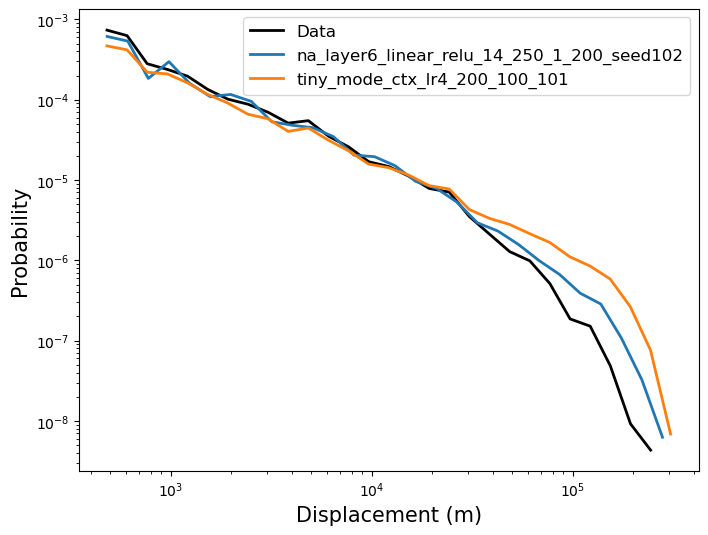

In [25]:
plt.figure(figsize=(8, 6))

# plotting
powerlaw.plot_pdf(true_jp, label="Data", color="k", linewidth=2)
# powerlaw.plot_pdf(source_jp, label="source")
for predict, label in zip(predict_jp, diff_file_name):
    # powerlaw.plot_pdf(predict, label=label, linewidth=2, color="tomato")
    powerlaw.plot_pdf(predict, label=label, linewidth=2)

# powerlaw.plot_pdf(markov_jp, label="Markov", alpha=0.7,  color=colors[4], linewidth=1.5)
# powerlaw.plot_pdf(ar_jp, label="MHSA", alpha=0.7, color=colors[5], linewidth=1.5)
# powerlaw.plot_pdf(gan_jp, label="MovSim", alpha=0.7, color=colors[6], linewidth=1.5)
# powerlaw.plot_pdf(epr_jp, label="EPR", alpha=0.7, color=colors[0], linewidth=1.5)
# powerlaw.plot_pdf(container_jp, label="Container", alpha=0.7, color=colors[2], linewidth=1.5)

# fit power law
# fit = powerlaw.Fit(true_jp, xmin=1)
# fit.power_law.plot_pdf(linestyle="--", label="powerlaw fit")
# fit.truncated_power_law.plot_pdf(linestyle="--", label="truncated power law")
# fit.lognormal.plot_pdf(linestyle="--", label="lognormal fit")

plt.legend(prop={"size": 12})
plt.xlabel("Displacement (m)", fontsize=15)
plt.ylabel("Probability", fontsize=15)

# plt.savefig(r'.\metrics\figures\jump.png', bbox_inches='tight', dpi=600)

plt.show()

### Divergence

In [537]:
predict = np.log(predict_jp[0])
true = np.log(true_jp)
source = np.log(source_jp)

min = predict.min()
max = predict.max()

In [538]:
pred_dist_p, _ = np.histogram(predict, bins=1000, range=(min, max))
true_dist_p, _ =  np.histogram(true, bins=1000, range=(min, max))
source_dist_p, _ =  np.histogram(source, bins=1000, range=(min, max))

pred_true_js = distance.jensenshannon(pred_dist_p, true_dist_p)
source_true_js = distance.jensenshannon(source_dist_p, true_dist_p)

print(f"Prediction and True: {pred_true_js:.3f}\t Source and True: {source_true_js:.3f}")

Prediction and True: 0.150	 Source and True: 0.095


In [539]:
markov = np.log(markov_jp)
ar = np.log(ar_jp)
gan = np.log(gan_jp)
epr =  np.log(epr_jp)

In [540]:
markov_dist_p, _ =  np.histogram(markov, bins=1000, range=(min, max))
markov_true_js = distance.jensenshannon(markov_dist_p, true_dist_p)

ar_dist_p, _ =  np.histogram(ar, bins=1000, range=(min, max))
ar_true_js = distance.jensenshannon(ar_dist_p, true_dist_p)

gan_dist_p, _ =  np.histogram(gan, bins=1000, range=(min, max))
gan_true_js = distance.jensenshannon(gan_dist_p, true_dist_p)

print(f"Markov and True: {markov_true_js:.3f}\t AR and True: {ar_true_js:.3f}\t GAN and True: {gan_true_js:.3f}")

epr_dist_p, _ =  np.histogram(epr, bins=1000, range=(min, max))
epr_true_js = distance.jensenshannon(epr_dist_p, true_dist_p)

print(f"EPR and True: {epr_true_js:.3f}")

Markov and True: 0.310	 AR and True: 0.138	 GAN and True: 0.213
EPR and True: 0.248


### Wasserstein distance

In [1262]:
wasserstein_distance(true_jp, source_jp)

2125.1039345849977

In [1263]:
for pred_variant in predict_jp:
    print(wasserstein_distance(true_jp, pred_variant))

3889.0498250822043
2539.733341763057
15928.4955635633
18930.28601557697
20176.20852334464
22723.770183638484


In [1268]:
wasserstein_distance(true_jp, markov_jp), \
wasserstein_distance(true_jp, ar_jp),\
wasserstein_distance(true_jp, gan_jp), \
wasserstein_distance(true_jp, epr_jp),\
wasserstein_distance(true_jp, container_jp)

(2223.081522217768,
 1490.8059438635723,
 8128.2145123329055,
 15882.127010227026,
 1145.8753095443494)

### Loglikelihood

In [547]:
# determine the best fit distributions

fit = powerlaw.Fit(true_jp, xmin = 1, xmin_distribution='power_law')
print(getAIC(fit, true_jp))
fit = powerlaw.Fit(predict_jp[0], xmin = 1, xmin_distribution='power_law')
print(getAIC(fit, predict_jp[0]))

{'truncated_power_law': 0.0, 'power_law': 0.0, 'lognormal': 1.0}
{'truncated_power_law': 0.0, 'power_law': 0.0, 'lognormal': 1.0}


In [548]:
predict_lk = powerlaw.Fit(predict_jp[0], xmin=1).lognormal.loglikelihoods(true_jp)
markov_lk = powerlaw.Fit(markov_jp, xmin=1).lognormal.loglikelihoods(true_jp)
ar_lk = powerlaw.Fit(ar_jp, xmin=1).lognormal.loglikelihoods(true_jp)
gan_lk = powerlaw.Fit(gan_jp, xmin=1).lognormal.loglikelihoods(true_jp)
epr_lk = powerlaw.Fit(epr_jp, xmin=1).lognormal.loglikelihoods(true_jp)
container_lk = powerlaw.Fit(container_jp, xmin=1).lognormal.loglikelihoods(true_jp)

In [549]:
loglikelihood_ratio(predict_lk, markov_lk),\
loglikelihood_ratio(predict_lk, ar_lk),\
loglikelihood_ratio(predict_lk, gan_lk),\
loglikelihood_ratio(predict_lk, epr_lk),\
loglikelihood_ratio(predict_lk, container_lk)

((-3414.3317332006636, 1.591263626242219e-26),
 (-6227.598665433064, 1.1185464433545021e-95),
 (29272.73114165142, 0.0),
 (160214.37100576112, 0.0),
 (-12680.499763132106, 0.0))

# Visit frequency - dataset location

In [26]:
def get_loc_p(ls):
    visits = np.zeros(shape=(len(all_locs)), dtype=float)
    for seq in ls:
        locs = seq - 1 # padding

        visits[locs] += 1
    visits.sort()
    visits = visits[::-1]
    return visits

In [27]:
predict_p = [get_loc_p(predict) for predict in predict_ls]

print(predict_p)

predict = [ p[p>0] / p.sum() for p in predict_p ]

[array([5197., 2614., 2319., ...,    0.,    0.,    0.]), array([5078., 2265., 1918., ...,    0.,    0.,    0.])]


In [28]:
true_p = get_loc_p(true_ls)
# source_p = get_loc_p(src_ls)

true_p

array([5494., 3176., 3078., ...,    0.,    0.,    0.])

In [29]:
true = true_p[true_p>0] / true_p.sum()
# source = source_p[source_p>0] / source_p.sum()

In [30]:
markov_p = get_loc_p(markov_ls)
ar_p = get_loc_p(ar_ls)
gan_p = get_loc_p(gan_ls)
epr_p = get_loc_p(epr_ls)
container_p = get_loc_p(container_ls)

In [31]:
markov_p, ar_p, gan_p, epr_p, container_p

(array([1762.,  791.,  771., ...,    0.,    0.,    0.]),
 array([4313., 1985., 1772., ...,    0.,    0.,    0.]),
 array([1719., 1099.,  925., ...,    0.,    0.,    0.]),
 array([6580., 3695., 2833., ...,    0.,    0.,    0.]),
 array([4960., 2253., 2191., ...,    0.,    0.,    0.]))

In [32]:
markov = markov_p[markov_p>0] / markov_p.sum()
ar = ar_p[ar_p>0] / ar_p.sum()
gan = gan_p[gan_p>0] / gan_p.sum()
epr = epr_p[epr_p>0] / epr_p.sum()
container = container_p[container_p>0] / container_p.sum()

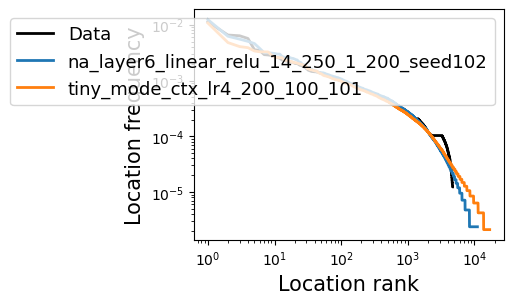

In [33]:
plt.figure(figsize=(4, 3))

plt.plot(np.arange(len(true[:-200])) + 1, true[:-200], color="k", linewidth=2, label="Data")
# plt.plot(np.arange(len(source)) + 1, source, label="source")
# plotting
for pre, label in zip(predict, diff_file_name):
    # plt.plot(np.arange(len(pre[:-5000])) + 1, pre[:-5000], color="tomato", linewidth=2, label=label)
    # plt.plot(np.arange(len(pre)) + 1, pre, color="tomato", linewidth=2, label=label)
    plt.plot(np.arange(len(pre)) + 1, pre, linewidth=2, label=label)

# plt.plot(np.arange(len(ar)) + 1, ar, label="MHSA decode (Ours)")
# plt.plot(np.arange(len(markov)) + 1, markov, label="Markov")
# plt.plot(np.arange(len(gan)) + 1, gan, label="MovSim")
# plt.plot(np.arange(len(epr[:-20000])) + 1, epr[:-20000], color=colors[0], linewidth=1.5, alpha=0.7, label="EPR")
# plt.plot(np.arange(len(container[:-10000])) + 1, container[:-10000], color=colors[2], linewidth=1.5, alpha=0.7, label="Container")

plt.xscale("log")
plt.yscale("log")

plt.xlabel("Location rank", fontsize=15)
plt.ylabel("Location frequency", fontsize=15)
plt.legend(prop={"size": 13})
# plt.savefig(r'.\metrics\figures\fk_overall.png', bbox_inches='tight', dpi=600)

plt.show()

In [37]:
# predict = np.log(predict_p[:100])
# true = np.log(true_p[:100])
# source = np.log(source_p[:100])

predict = predict_p
true = true_p
source = source_p

NameError: name 'source_p' is not defined

In [427]:
true

array([5494., 3176., 3078., ...,    0.,    0.,    0.])

In [425]:
pred_true_js = distance.jensenshannon(predict, true)
source_true_js = distance.jensenshannon(source, true)

print(f"Prediction and True: {pred_true_js:.3f}\t Source and True: {source_true_js:.3f}")

C:\ProgramData\Anaconda3\envs\gene\Lib\site-packages\scipy\spatial\distance.py:1261: RuntimeWarning: invalid value encountered in divide
  p = p / np.sum(p, axis=axis, keepdims=True)


TypeError: unsupported format string passed to numpy.ndarray.__format__

In [127]:
markov_true_js = distance.jensenshannon(markov_p, true)
ar_true_js = distance.jensenshannon(ar_p, true)
gan_true_js = distance.jensenshannon(gan_p, true)

print(f"Markov and True: {markov_true_js:.3f}\t AR and True: {ar_true_js:.3f}\t GAN and True: {gan_true_js:.3f}")

Markov and True: 0.365	 AR and True: 0.166	 GAN and True: 0.214


In [234]:
epr_true_js = distance.jensenshannon(epr_p, true)

print(f"EPR and True: {epr_true_js:.3f}")

EPR and True: 0.221


# Visit frequency - individual location (max 50)

In [34]:
def get_individual_loc_p(ls, max_len = 50):
    visits = np.zeros(shape=(max_len), dtype=float)

    for seq in ls:
        _, counts = np.unique(seq, return_counts=True)
        counts.sort()
        counts = counts[::-1]

        if len(counts) > max_len:
            counts = counts[:max_len]
        else:
            counts = np.pad(counts, (0, max_len - len(counts)))
        
        visits += counts/counts.sum()

    visits = visits/len(ls)
    return visits

In [35]:
predict_ind_p = [get_individual_loc_p(p) for p in predict_ls]

In [36]:
true_ind_p = get_individual_loc_p(true_ls)
# source_ind_p = get_individual_loc_p(src_ls)

In [1202]:
predict = [p[p>0] for p in predict_ind_p]
true = true_ind_p[true_ind_p>0]
# source = source_ind_p[source_ind_p>0]

In [1203]:
markov_p = get_individual_loc_p(markov_ls)
ar_p = get_individual_loc_p(ar_ls)
gan_p = get_individual_loc_p(gan_ls)
epr_ind_p = get_individual_loc_p(epr_ls)
container_ind_p = get_individual_loc_p(container_ls)

markov = markov_p[markov_p>0]
ar = ar_p[ar_p>0]
gan = gan_p[gan_p>0]
epr = epr_ind_p[epr_ind_p>0]
container = container_ind_p[container_ind_p>0]

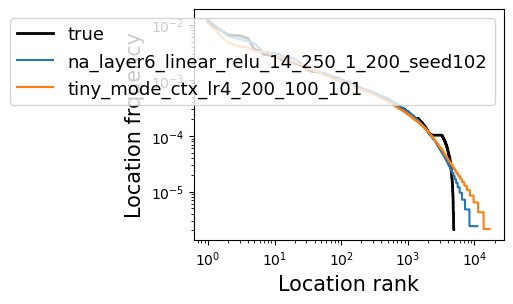

In [37]:
plt.figure(figsize=(4, 3))


# plotting
plt.plot(np.arange(len(true)) + 1, true, color="k", linewidth=2, label="true")
# plt.plot(np.arange(len(source)) + 1, source, label="source")

for pre, label in zip(predict, diff_file_name):
    # plt.plot(np.arange(len(pre)) + 1, pre, color="tomato", linewidth=2, label=label)
    plt.plot(np.arange(len(pre)) + 1, pre, label=label)


# plt.plot(np.arange(len(markov)) + 1, markov, label="Markov", color=colors[4], linewidth=1.5, alpha=0.7)
# plt.plot(np.arange(len(ar)) + 1, ar, label="MHSA", color=colors[5], linewidth=1.5, alpha=0.7)
# plt.plot(np.arange(len(gan)) + 1, gan, label="MovSim", color=colors[6], linewidth=1.5, alpha=0.7)
# plt.plot(np.arange(len(epr)) + 1, epr, label="EPR", color=colors[0], linewidth=1.5, alpha=0.7)
# plt.plot(np.arange(len(container[:-2])) + 1, container[:-2], label="Container", color=colors[2], linewidth=1.5, alpha=0.7)

plt.xscale("log")
plt.yscale("log")
plt.legend(prop={"size": 13})

plt.xlabel("Location rank", fontsize=15)
plt.ylabel("Location frquency", fontsize=15)

# plt.savefig(r'.\metrics\figures\lk_all.png', bbox_inches='tight', dpi=600)
plt.show()


In [876]:
predict = [p[p>0] for p in predict_ind_p]
true = true_ind_p[true_ind_p>0]
source = source_ind_p[source_ind_p>0]

ar = ar_p[ar_p>0]
markov = markov_p[markov_p>0]
gan = gan_p[gan_p>0]
epr = epr_ind_p[epr_ind_p>0]

NameError: name 'source_ind_p' is not defined

In [364]:
pred_true_js = distance.jensenshannon(predict_ind_p[0], true_ind_p)
source_true_js = distance.jensenshannon(source_ind_p, true_ind_p)

print(f"Prediction and True: {pred_true_js:.3f}\t Source and True: {source_true_js:.3f}")

Prediction and True: 0.040	 Source and True: 0.092


In [365]:
markov_true_js = distance.jensenshannon(markov_p, true_ind_p)
ar_true_js = distance.jensenshannon(ar_p, true_ind_p)
gan_true_js = distance.jensenshannon(gan_p, true_ind_p)

print(f"Markov and True: {markov_true_js:.3f}\t AR and True: {ar_true_js:.3f}\t GAN and True: {gan_true_js:.3f}")

epr_true_js = distance.jensenshannon(epr_ind_p, true_ind_p)

print(f"EPR and True: {epr_true_js:.3f}")

Markov and True: 0.287	 AR and True: 0.086	 GAN and True: 0.270
EPR and True: 0.172


In [38]:
# na_layer6_14_200_1_200

def get_ind_loc_rank_arr(ls, max_len = 50):
    rank_long_ls = []
    for seq in ls:
        _, counts = np.unique(seq, return_counts=True)
        counts.sort()
        counts = counts[::-1]
    
        rank_ls = np.repeat(np.arange(len(counts)) + 1, counts)
    
        rank_long_ls.append(rank_ls)
    
    return np.concatenate(rank_long_ls)

predict_rank_arr = [get_ind_loc_rank_arr(p) for p in predict_ls]
true_rank_arr = get_ind_loc_rank_arr(true_ls)
source_rank_arr = get_ind_loc_rank_arr(src_ls)

markov_rank_arr = get_ind_loc_rank_arr(markov_ls)
ar_rank_arr = get_ind_loc_rank_arr(ar_ls)
gan_rank_arr = get_ind_loc_rank_arr(gan_ls)
epr_rank_arr = get_ind_loc_rank_arr(epr_ls)
container_rank_arr = get_ind_loc_rank_arr(container_ls)

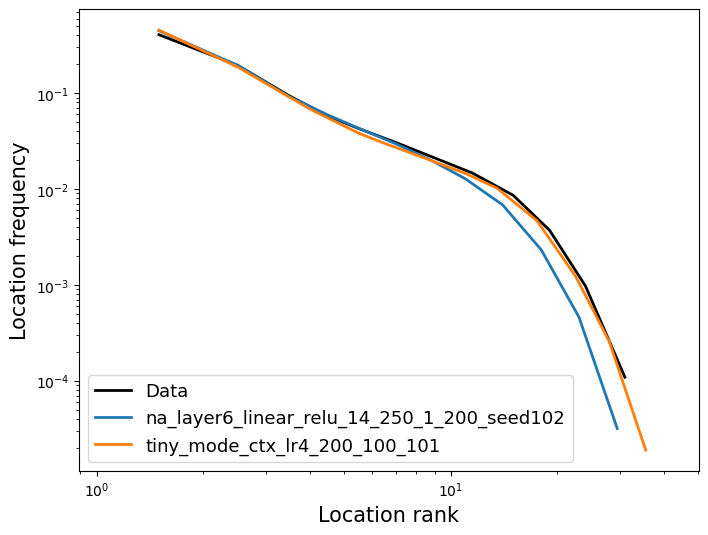

In [39]:
plt.figure(figsize=(8, 6))

# fit power law
fit = powerlaw.Fit(true_rank_arr, xmin=1)

# plotting
powerlaw.plot_pdf(true_rank_arr, label="Data", color="k", linewidth=2)
# powerlaw.plot_pdf(source_rank_arr, label="source")

for pre, label in zip(predict_rank_arr, diff_file_name):
    powerlaw.plot_pdf(pre, label=label, linewidth=2)
    # powerlaw.plot_pdf(pre, label=label, color="tomato", linewidth=2)

# powerlaw.plot_pdf(markov_rank_arr, label="markov", alpha=0.7, color=colors[4], linewidth=1.5)
# powerlaw.plot_pdf(ar_rank_arr, label="ar", alpha=0.7, color=colors[5], linewidth=1.5)
# powerlaw.plot_pdf(gan_rank_arr, label="gan", alpha=0.7, color=colors[6], linewidth=1.5)
# powerlaw.plot_pdf(epr_rank_arr, label="epr", alpha=0.7, color=colors[0], linewidth=1.5)
# powerlaw.plot_pdf(container_rank_arr, label="container", alpha=0.7, color=colors[2], linewidth=1.5)

# fit.power_law.plot_pdf(linestyle="--", label="powerlaw fit")
# fit.truncated_power_law.plot_pdf(linestyle="--", label="truncated power law")
# fit.lognormal.plot_pdf(linestyle="--", label="lognormal fit")

plt.xlabel("Location rank", fontsize=15)
plt.ylabel("Location frequency", fontsize=15)
# plt.xscale("linear")
plt.xlim([10**-0.05, 10**1.7])
# plt.savefig(r'.\metrics\figures\lk_rank.png', bbox_inches='tight', dpi=600)
plt.legend(prop={"size": 13})
plt.show()

In [1269]:
for arr in predict_rank_arr:
    print(wasserstein_distance(arr, true_rank_arr))

0.5513809423800689
0.4148782553192998
0.8842389928420623
0.6762816632063958
0.6821974962532542
0.5415332384044803


In [174]:
wasserstein_distance(predict_rank_arr[0], true_rank_arr),\
wasserstein_distance(markov_rank_arr, true_rank_arr),\
wasserstein_distance(ar_rank_arr, true_rank_arr),\
wasserstein_distance(gan_rank_arr, true_rank_arr),\
wasserstein_distance(epr_rank_arr, true_rank_arr),\
wasserstein_distance(container_rank_arr, true_rank_arr)

(0.3472060550112739,
 2.0381512331338243,
 0.8512740762916583,
 5.042072322301877,
 2.629373088211085,
 0.6874406092252777)

In [315]:
predict_lk = powerlaw.Fit(predict_rank_arr[0], xmin=1).power_law.loglikelihoods(true_rank_arr)
markov_lk = powerlaw.Fit(markov_rank_arr, xmin=1).power_law.loglikelihoods(true_rank_arr)
ar_lk = powerlaw.Fit(ar_rank_arr, xmin=1).power_law.loglikelihoods(true_rank_arr)
gan_lk = powerlaw.Fit(gan_rank_arr, xmin=1).power_law.loglikelihoods(true_rank_arr)
epr_lk = powerlaw.Fit(epr_rank_arr, xmin=1).power_law.loglikelihoods(true_rank_arr)
container_lk = powerlaw.Fit(container_rank_arr, xmin=1).power_law.loglikelihoods(true_rank_arr)

In [316]:
loglikelihood_ratio(predict_lk, markov_lk),\
loglikelihood_ratio(predict_lk, ar_lk),\
loglikelihood_ratio(predict_lk, gan_lk),\
loglikelihood_ratio(predict_lk, epr_lk),\
loglikelihood_ratio(predict_lk, container_lk)

((794947.7643657704, 0.0),
 (65084.523087300346, 0.0),
 (266951.9782064898, 0.0),
 (112296.93936051158, 0.0),
 (10605.905037245619, 1.938416928414071e-243))

# Rg

## Overall

In [40]:
# na_layer6_linear_relu_14_250_1_200_seed101

def get_rg(ls, geo_x, geo_y):
    rgs = []

    for seq in ls:
        locs = seq - 1 # padding

        xs = np.take(geo_x, locs)
        ys = np.take(geo_y, locs)

        x_center = np.average(xs)
        y_center = np.average(ys)

        square_rg = np.average((xs - x_center) ** 2 + (ys - y_center) ** 2)

        rgs.append(np.sqrt(square_rg))
    return np.array(rgs, dtype=float)

In [41]:
geo_x = all_locs["geometry"].x.values
geo_y = all_locs["geometry"].y.values

predict_rg = [get_rg(p, geo_x, geo_y) for p in predict_ls]

predict_rg = [p[p>1] for p in predict_rg]

In [42]:
true_rg = get_rg(true_ls, geo_x, geo_y)
# source_rg = get_rg(src_ls, geo_x, geo_y)

true_rg = true_rg[true_rg>1]
# source_rg = source_rg[source_rg>1]

In [43]:
markov_rg = get_rg(markov_ls, geo_x, geo_y)
markov_rg = markov_rg[markov_rg>1]

ar_rg = get_rg(ar_ls, geo_x, geo_y)
ar_rg = ar_rg[ar_rg>1]

gan_rg = get_rg(gan_ls, geo_x, geo_y)
gan_rg = gan_rg[gan_rg>1]

epr_rg = get_rg(epr_ls, geo_x, geo_y)
epr_rg = epr_rg[epr_rg>1]

container_rg = get_rg(container_ls, geo_x, geo_y)
container_rg = container_rg[container_rg>1]

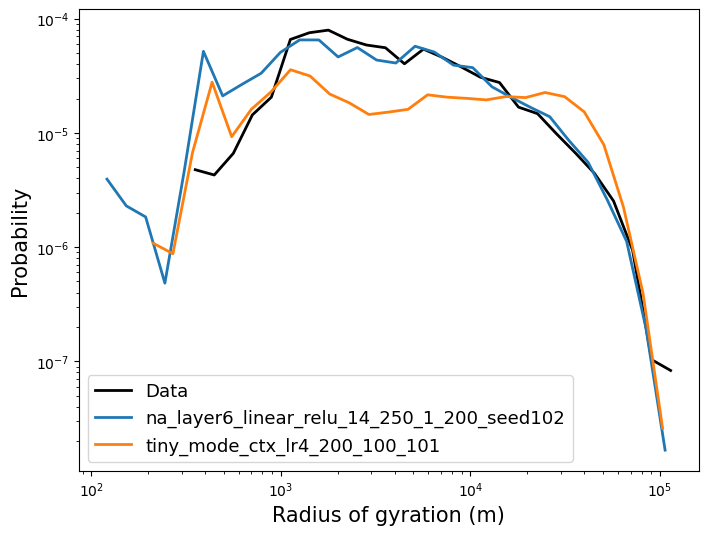

In [44]:
plt.figure(figsize=(8, 6))

# fit power law
fit = powerlaw.Fit(true_rg, xmin=1)

# plotting
powerlaw.plot_pdf(true_rg, label="Data", color="k", linewidth=2)
# powerlaw.plot_pdf(source_rg, label="source")

for pre, label in zip(predict_rg, diff_file_name):
    # powerlaw.plot_pdf(pre, label=label, linewidth=2, color="tomato")
    powerlaw.plot_pdf(pre, label=label, linewidth=2)

# powerlaw.plot_pdf(markov_rg, label="markov", alpha=0.7, color=colors[4], linewidth=1.5)
# powerlaw.plot_pdf(ar_rg, label="ar", alpha=0.7, color=colors[5], linewidth=1.5)
# powerlaw.plot_pdf(gan_rg, label="gan", alpha=0.7, color=colors[6], linewidth=1.5)
# powerlaw.plot_pdf(epr_rg, label="epr", alpha=0.7, color=colors[0], linewidth=1.5)
# powerlaw.plot_pdf(container_rg, label="container", alpha=0.7, color=colors[2], linewidth=1.5)

# fit.power_law.plot_pdf(linestyle="--", label="powerlaw fit")
# fit.truncated_power_law.plot_pdf(linestyle="--", label="truncated power law")
# fit.lognormal.plot_pdf(linestyle="--", label="lognormal fit")

plt.ylabel("Probability", fontsize=15)
plt.xlabel("Radius of gyration (m)", fontsize=15)

# plt.savefig(r'.\metrics\figures\rg.png', bbox_inches='tight', dpi=600)
plt.legend(prop={"size": 13})
plt.show()

### Divergence 

In [458]:
predict = np.log(predict_rg[0])
true = np.log(true_rg)
source = np.log(source_rg)

min = predict.min()
max = predict.max()

In [459]:

pred_rg_p, _ = np.histogram(predict, bins=1000, range=(min, max))
true_rg_p, _ =  np.histogram(true, bins=1000, range=(min, max))
source_rg_p, _ =  np.histogram(source, bins=1000, range=(min, max))

pred_true_js = distance.jensenshannon(pred_rg_p, true_rg_p)
source_true_js = distance.jensenshannon(source_rg_p, true_rg_p)

print(f"Prediction and True: {pred_true_js:.3f}\t Source and True: {source_true_js:.3f}")

Prediction and True: 0.172	 Source and True: 0.679


In [460]:
markov = np.log(markov_rg)
ar = np.log(ar_rg)
gan = np.log(gan_rg)
epr = np.log(epr_rg)

In [461]:
markov_rg_p, _ =  np.histogram(markov, bins=1000, range=(min, max))
markov_true_js = distance.jensenshannon(markov_rg_p, true_rg_p)

ar_rg_p, _ =  np.histogram(ar, bins=1000, range=(min, max))
ar_true_js = distance.jensenshannon(ar_rg_p, true_rg_p)

gan_rg_p, _ =  np.histogram(gan, bins=1000, range=(min, max))
gan_true_js = distance.jensenshannon(gan_rg_p, true_rg_p)

print(f"Markov and True: {markov_true_js:.3f}\t AR and True: {ar_true_js:.3f}\t GAN and True: {gan_true_js:.3f}")

epr_rg_p, _ =  np.histogram(epr, bins=1000, range=(min, max))
epr_true_js = distance.jensenshannon(epr_rg_p, true_rg_p)

print(f"EPR and True: {epr_true_js:.3f}")

Markov and True: 0.395	 AR and True: 0.233	 GAN and True: 0.534
EPR and True: 0.346


### Wasserstein distance

In [1270]:
for predict_variations in predict_rg:
    print(wasserstein_distance(predict_variations, true_rg))

804.0831335139488
505.13966891746395
6171.004972192076
9210.33306387995
10000.133996562332
12599.233051050616


In [1217]:
wasserstein_distance(markov_rg, true_rg),\
wasserstein_distance(ar_rg, true_rg),\
wasserstein_distance(gan_rg, true_rg),\
wasserstein_distance(epr_rg, true_rg),\
wasserstein_distance(container_rg, true_rg)

(10101.730765153434,
 5137.196647919567,
 34096.41713049315,
 12824.745832276036,
 3578.4341492955173)

### Loglikelihood

In [555]:
# determine the best fit distributions

fit = powerlaw.Fit(true_rg, xmin = 1, xmin_distribution='power_law')
print(getAIC(fit, true_rg))
fit = powerlaw.Fit(predict_rg[0], xmin = 1, xmin_distribution='power_law')
print(getAIC(fit, predict_rg[0]))

{'truncated_power_law': 0.0, 'power_law': 0.0, 'lognormal': 1.0}
{'truncated_power_law': 0.0, 'power_law': 0.0, 'lognormal': 1.0}


In [556]:
predict_lk = powerlaw.Fit(predict_rg[0], xmin=1).lognormal.loglikelihoods(true_rg)
markov_lk = powerlaw.Fit(markov_rg, xmin=1).lognormal.loglikelihoods(true_rg)
ar_lk = powerlaw.Fit(ar_rg, xmin=1).lognormal.loglikelihoods(true_rg)
gan_lk = powerlaw.Fit(gan_rg, xmin=1).lognormal.loglikelihoods(true_rg)
epr_lk = powerlaw.Fit(epr_rg, xmin=1).lognormal.loglikelihoods(true_rg)
container_lk = powerlaw.Fit(container_rg, xmin=1).lognormal.loglikelihoods(true_rg)

In [557]:
loglikelihood_ratio(predict_lk, markov_lk),\
loglikelihood_ratio(predict_lk, ar_lk),\
loglikelihood_ratio(predict_lk, gan_lk),\
loglikelihood_ratio(predict_lk, epr_lk),\
loglikelihood_ratio(predict_lk, container_lk)

((16524.710932785376, 0.0),
 (4346.202318618257, 0.0),
 (79916.6823140971, 0.0),
 (31358.36097032501, 0.0),
 (940.6211321269215, 7.624054395397612e-92))

## Evolution

In [45]:
def get_rg_evolution(seq, geo_x, geo_y, max_len=50):
    locs = seq - 1 # padding

    xs = np.take(geo_x, locs)
    ys = np.take(geo_y, locs)

    current_rg = [0]
    for i in range(1, len(xs)):

        x_center = np.average(xs[:i])
        y_center = np.average(ys[:i])

        square_rg = np.average((xs[:i] - x_center) ** 2 + (ys[:i] - y_center) ** 2)

        current_rg.append(np.sqrt(square_rg))
    
    current_rg = np.array(current_rg, dtype=float)
    if len(current_rg) > max_len:
        current_rg = current_rg[:max_len]
    else:
        current_rg = np.pad(current_rg, (0, max_len - len(current_rg)), constant_values=np.nan)
            
    return current_rg

geo_x = all_locs["geometry"].x.values
geo_y = all_locs["geometry"].y.values


In [46]:
predict_rge = [_apply_parallel(p, get_rg_evolution, geo_x=geo_x, geo_y=geo_y, n=-1) for p in predict_ls]

In [47]:
true_rge = _apply_parallel(true_ls, get_rg_evolution, geo_x=geo_x, geo_y=geo_y, n=-1)
# source_rge = _apply_parallel(src_ls, get_rg_evolution, geo_x=geo_x, geo_y=geo_y, n=-1)

In [48]:
markov_rge = _apply_parallel(markov_ls, get_rg_evolution, geo_x=geo_x, geo_y=geo_y, n=-1)
epr_rge = _apply_parallel(epr_ls, get_rg_evolution, geo_x=geo_x, geo_y=geo_y, n=-1)
ar_rge = _apply_parallel(ar_ls, get_rg_evolution, geo_x=geo_x, geo_y=geo_y, n=-1)
gan_rge = _apply_parallel(gan_ls, get_rg_evolution, geo_x=geo_x, geo_y=geo_y, n=-1)

container_rge = _apply_parallel(container_ls, get_rg_evolution, geo_x=geo_x, geo_y=geo_y, n=-1)

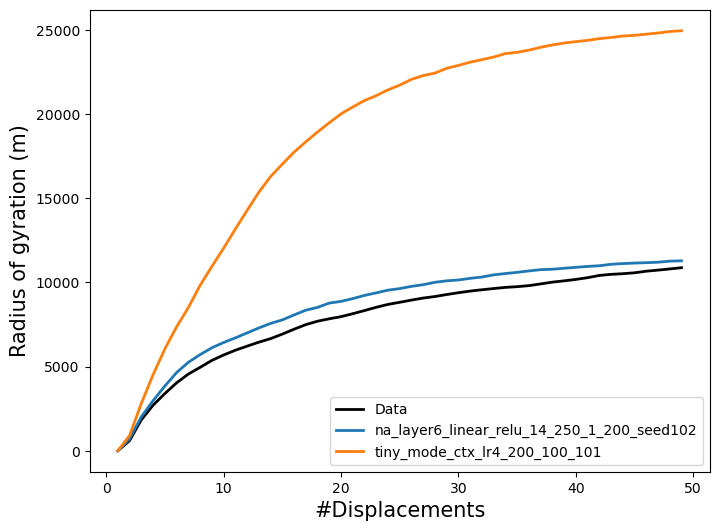

In [50]:
# na_layer6_linear_relu_14_250_1_200_seed102

def get_fit(rge, x_log):
    y = np.nanmedian(rge, axis = 0)[:-1]
    # x_log = np.log(np.arange(len(y)) + 1)
    slope, intercept, _, _, _ = linregress(x_log, y)

    return slope, intercept


plt.figure(figsize=(8, 6))

x = np.arange(1, 50)
x_log = np.log(x)

# plotting
plt.plot(x, np.nanmedian(true_rge, axis = 0)[1:], color="k", linewidth=2, label="Data")

# slope, intercept = get_fit(true_rge, x_log)
# plt.plot(np.exp(x_log)[1:], x_log[1:]*slope+intercept, "--", color="k")

# plt.plot(x, np.nanquantile(true_rge, q=0.25, axis=0)[1:], '--', color = colors[0], alpha=0.3)
# plt.plot(x, np.nanquantile(true_rge, q=0.75, axis=0)[1:], '--', color = colors[0], alpha=0.3)
# plt.fill_between(x, np.nanquantile(true_rge, q=0.25, axis=0)[1:], np.nanquantile(true_rge, q=0.75, axis=0)[1:], color = colors[0], alpha=0.3)

# plt.plot(source_rge, label="source")

for i, (pre, label) in enumerate(zip(predict_rge, diff_file_name)):
    # plt.plot(x, np.nanmedian(pre, axis=0)[1:], linewidth=2, label=label, color="tomato")
    plt.plot(x, np.nanmedian(pre, axis=0)[1:], linewidth=2, label=label)
    
    # slope, intercept = get_fit(pre, x_log)
    # plt.plot(np.exp(x_log)[1:], x_log[1:]*slope+intercept, "--", color="tomato")
    # plt.plot(x, np.nanmedian(pre, axis=0)[1:], linewidth=2, label=label)
    # plt.plot(x, np.nanquantile(pre, q=0.25, axis=0)[1:], '--', color = colors[i+1], alpha=0.3)
    # plt.plot(x, np.nanquantile(pre, q=0.75, axis=0)[1:], '--', color = colors[i+1], alpha=0.3)
    # plt.fill_between(x, np.nanquantile(pre, q=0.25, axis=0)[1:], np.nanquantile(pre, q=0.75, axis=0)[1:], color = colors[i+1], alpha=0.3)

# plt.plot(x, np.nanmedian(markov_rge, axis = 0)[1:], color = colors[4], linewidth=1.5, label="Markov", alpha=0.7)
# plt.plot(x, np.nanmedian(ar_rge, axis = 0)[1:], color = colors[5], label="MHSA", alpha=0.7)
# plt.plot(x, np.nanmedian(gan_rge, axis = 0)[1:], color = colors[6], linewidth=1.5, label="MovSim", alpha=0.7)
# plt.plot(x, np.nanmedian(epr_rge, axis = 0)[1:], color=colors[0], linewidth=1.5, label="EPR", alpha=0.7)
# slope, intercept = get_fit(epr_rge, x_log)
# plt.plot(np.exp(x_log)[1:], x_log[1:]*slope+intercept, "--", color=colors[0], alpha=0.7)

# plt.plot(x, np.nanmedian(container_rge, axis = 0)[1:], color=colors[2], linewidth=1.5, label="Container", alpha=0.7)


plt.xlabel("#Displacements", fontsize=15)
plt.ylabel("Radius of gyration (m)", fontsize=15)
plt.legend(prop={"size": 10})

# plt.savefig(r'.\metrics\figures\rg_evolution_all.png', bbox_inches='tight', dpi=600)
plt.show()

### Fit

In [891]:
cut = 2

y = np.nanmedian(true_rge, axis = 0)[cut:]
x = np.log(np.arange(len(y)) + 1)
print(stats.linregress(x, y))

for predict_variation in predict_rge:
    y = np.nanmedian(predict_variation, axis = 0)[cut:]
    print(stats.linregress(x, y))

LinregressResult(slope=2875.380653561889, intercept=-401.2924740358367, rvalue=0.9966999746219484, pvalue=7.992243632684262e-52, stderr=34.52765069223505, intercept_stderr=105.62517053583069)
LinregressResult(slope=6172.546409370768, intercept=-2958.0776651473225, rvalue=0.9861268042008061, pvalue=1.5784560544136267e-37, stderr=153.19494272481762, intercept_stderr=468.6459004919987)
LinregressResult(slope=6200.509752542976, intercept=-2956.786874876805, rvalue=0.9876013637038327, pvalue=1.2093855840836779e-38, stderr=145.31766182764326, intercept_stderr=444.54813764276435)


In [349]:
cut = 2

y = np.nanmedian(true_rge, axis = 0)[cut:]
x = np.log(np.arange(len(y)) + 1)
print(stats.linregress(x, y))

y = np.nanmedian(predict_rge[0], axis = 0)[cut:]
print(stats.linregress(x, y))

y = np.nanmedian(epr_rge, axis = 0)[cut:]
print(stats.linregress(x, y))

y = np.nanmedian(container_rge, axis = 0)[cut:]
print(stats.linregress(x, y))

print("markov_rge")
y = np.nanmedian(markov_rge, axis = 0)[cut:]
print(stats.linregress(x, y))

print("ar_rge")
y = np.nanmedian(ar_rge, axis = 0)[cut:]
print(stats.linregress(x, y))

print("gan_rge")
y = np.nanmedian(gan_rge, axis = 0)[cut:]
print(stats.linregress(x, y))


LinregressResult(slope=2875.380653561889, intercept=-401.2924740358367, rvalue=0.9966999746219484, pvalue=7.992243632684262e-52, stderr=34.52765069223505, intercept_stderr=105.62517053583069)
LinregressResult(slope=2967.216248265379, intercept=41.8583159364498, rvalue=0.9978610471510109, pvalue=3.773300781151778e-56, stderr=28.66047990899057, intercept_stderr=87.67663068100613)
LinregressResult(slope=6430.589693006258, intercept=4213.527108442751, rvalue=0.9814759338592268, pvalue=1.1605267337963794e-34, stderr=185.07799742228624, intercept_stderr=566.1808622431234)
LinregressResult(slope=3783.831980925417, intercept=-1265.6765105704108, rvalue=0.9926973382708331, pvalue=6.58368029933807e-44, stderr=67.79494809941005, intercept_stderr=207.3947346808159)
markov_rge
LinregressResult(slope=795.9891167905256, intercept=535.1803442210312, rvalue=0.9756517887016035, pvalue=5.868563071241963e-32, stderr=26.382873852157264, intercept_stderr=80.70909818622908)
ar_rge
LinregressResult(slope=1541

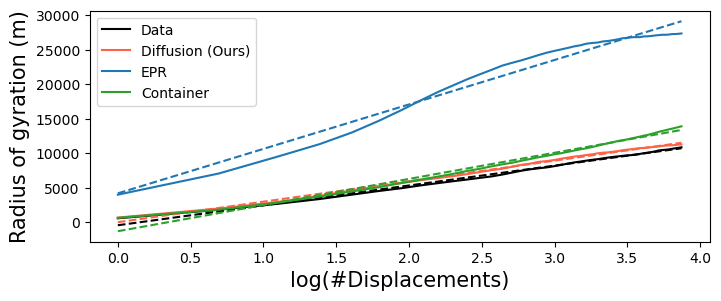

In [287]:
from scipy.stats import linregress

plt.figure(figsize=(8, 3))

cut = 2

y = np.nanmedian(true_rge, axis = 0)[cut:]
x = np.log(np.arange(len(y)) + 1)
slope, intercept, _, _, _ = linregress(x, y)
plt.plot(x, y, color="k",  label="Data")
plt.plot(x, x*slope+intercept, "--", color="k")

y = np.nanmedian(predict_rge[0], axis = 0)[cut:]
slope, intercept, _, _, _ = linregress(x, y)
plt.plot(x, y, color="tomato",  label="Diffusion (Ours)")
plt.plot(x, x*slope+intercept, "--", color="tomato")

y = np.nanmedian(epr_rge, axis = 0)[cut:]
slope, intercept, _, _, _ = linregress(x, y)
plt.plot(x, y, color=colors[0],  label="EPR")
plt.plot(x, x*slope+intercept, "--", color=colors[0])

y = np.nanmedian(container_rge, axis = 0)[cut:]
slope, intercept, _, _, _ = linregress(x, y)
plt.plot(x, y, color=colors[2],  label="Container")
plt.plot(x, x*slope+intercept, "--", color=colors[2])

# y = np.nanmedian(ar_rge, axis = 0)[cut:]
# slope, intercept, _, _, _ = linregress(x, y)
# plt.plot(x, y, color=colors[2],  label="MHSA")
# plt.plot(x, x*slope+intercept, "--", color=colors[2])

plt.xlabel("log(#Displacements)", fontsize=15)
plt.ylabel("Radius of gyration (m)", fontsize=15)

plt.legend(prop={"size": 10})
plt.show()

# Testing distribution

In [104]:
from utils.utils import load_data, _split_dataset

def get_train_test(sp, all_locs=None):
    sp.sort_values(by=["user_id", "start_day", "start_min"], inplace=True)
    sp.drop(columns={"started_at", "finished_at"}, inplace=True)
    sp["idx"] = sp.groupby("user_id").cumcount().add(1)

    # encoder user, 0 reserved for padding
    enc = OrdinalEncoder(dtype=np.int64)
    sp["user_id"] = enc.fit_transform(sp["user_id"].values.reshape(-1, 1)) + 1

    # split the datasets, user dependent 0.7, 0.2, 0.1
    train_data, vali_data, test_data = _split_dataset(sp)

    # encode unseen locations in validation and test into 0
    enc = OrdinalEncoder(dtype=np.int64, handle_unknown="use_encoded_value", unknown_value=-1).fit(
        all_locs["loc_id"].values.reshape(-1, 1)
    )
    # add 1 to account for 0 padding
    all_locs["loc_id"] = enc.transform(all_locs["loc_id"].values.reshape(-1, 1)) + 1

    train_data["location_id"] = enc.transform(train_data["location_id"].values.reshape(-1, 1)) + 1
    vali_data["location_id"] = enc.transform(vali_data["location_id"].values.reshape(-1, 1)) + 1
    test_data["location_id"] = enc.transform(test_data["location_id"].values.reshape(-1, 1)) + 1

    return train_data, vali_data, test_data, all_locs

def get_data_for_mechanistic(type):
    sp = pd.read_csv(os.path.join(f"./data/sp_{type}.csv"), index_col="id")
    loc = pd.read_csv(os.path.join("./data/loc_s2_level10_13.csv"), index_col="id")

    sp = load_data(sp, loc)

    # get all possible locations
    all_locs = pd.read_csv("./data/s2_loc_visited_level10_13.csv", index_col="id")
    all_locs["geometry"] = all_locs["geometry"].apply(wkt.loads)
    all_locs = gpd.GeoDataFrame(all_locs, geometry="geometry", crs="EPSG:4326")
    # transform to projected coordinate systems
    all_locs = all_locs.to_crs("EPSG:2056")

    train_data, vali_data, test_data, all_locs = get_train_test(sp, all_locs=all_locs)
    print(
        f"Max loc id {all_locs.loc_id.max()}, min loc id {all_locs.loc_id.min()}, unique loc id:{all_locs.loc_id.unique().shape[0]}"
    )

    return train_data, vali_data, test_data, all_locs

train_df, vali_df, test_df, all_locs_df = get_data_for_mechanistic(type="all")

Max loc id 14881, min loc id 1, unique loc id:14881


In [186]:
from sklearn.linear_model import LinearRegression
def get_parameter_estimate(df):
    df.sort_values(by=["start_day", "start_min"], inplace=True)

    loc = df["location_id"].values

    unique_count_ls = []
    for i in range(loc.shape[0]):
        unique_count_ls.append(len(np.unique(loc[: i + 1])))

    # big S
    unique_count_arr = np.array(unique_count_ls)

    # small n
    steps = np.arange(unique_count_arr.shape[0]) + 1

    logy = np.log(unique_count_arr)
    logx = np.log(steps)
    # print(logy, logx)
    reg = LinearRegression().fit(logx.reshape(-1, 1), logy)

    r = 1 / reg.coef_ - 1
    p = np.exp((reg.intercept_ - np.log(1 + r)) * (1 + r))

    return pd.Series([r[0], p[0]], index=["r", "p"])

train_vali_data = pd.concat([train_df, vali_df])
param_estimate = train_vali_data.groupby("user_id").apply(get_parameter_estimate)

In [189]:
from scipy.stats import norm
norm.fit(param_estimate.r), norm.fit(param_estimate.p)

((0.631684130639635, 0.3078206120000065),
 (0.5256114632862874, 0.27405772148554913))

In [190]:
param_estimate = param_estimate.loc[param_estimate["p"]<1]

array([[<Axes: title={'center': 'r'}>, <Axes: title={'center': 'p'}>]],
      dtype=object)

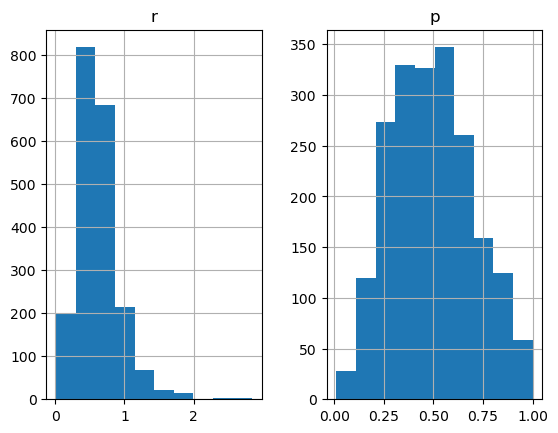

In [192]:
param_estimate.hist()

In [193]:
norm.fit(param_estimate.r), norm.fit(param_estimate.p)

((0.6217721474035965, 0.3032468230238075),
 (0.4943456871979018, 0.20562538359456128))

In [306]:
duration_hour = train_vali_data["act_duration"].values / 60
duration_hour = duration_hour[duration_hour > 0.1]

fit = powerlaw.Fit(duration_hour, xmin=0.1, xmin_distribution="lognormal")
# print("AIC criteria for wait time:", getAIC(fit, duration_hour))
print(f"Lognormal: parameter1: {fit.lognormal.parameter1:.4f}\t parameter2: {fit.lognormal.parameter2:.4f}")
# print(
#     f"Truncated power law: parameter1: {fit.truncated_power_law.parameter1:.2f}\t parameter2: {fit.truncated_power_law.parameter2:.2f}"
# )
# print(f"Power law: alpha: {fit.power_law.alpha:.2f}")


Lognormal: parameter1: 0.9748	 parameter2: 1.4316


In [311]:
duration_hour.max()

2013.6666666666667

In [312]:
fit.distribution_compare('power_law', 'exponential')

(-304319.6466017017, 0.0)

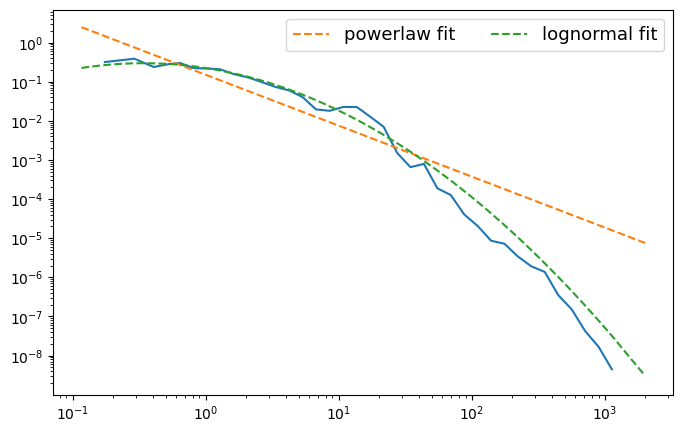

In [198]:
plt.figure(figsize=(8,5))

powerlaw.plot_pdf(duration_hour)

fit.power_law.plot_pdf(linestyle = '--', label='powerlaw fit')
# fit.truncated_power_law.plot_pdf(linestyle = '--', label='truncated power law')
fit.lognormal.plot_pdf(linestyle = '--', label='lognormal fit')

plt.legend(prop={'size': 13}, ncol=2)

plt.show()

In [313]:
train_vali_data["geometry"] = train_vali_data["geometry"].apply(wkt.loads)

TypeError: Expected bytes or string, got Point

In [314]:
from trackintel.geogr import point_haversine_dist
def get_jump_length(gdf):
    geom_arr = gdf.geometry.values

    res_ls = []
    for i in range(1, len(geom_arr)):
        res_ls.append(point_haversine_dist(geom_arr[i - 1].x, geom_arr[i - 1].y, geom_arr[i].x, geom_arr[i].y)[0])
    return res_ls


jump_length = gpd.GeoDataFrame(train_vali_data, geometry="geometry").groupby("user_id").apply(get_jump_length)


In [315]:
jump_length

user_id
1       [281.4220762892863, 1646.0597839192035, 2.5153...
2       [155.18895767606526, 221.79356387054705, 26330...
3       [1209.6737790118673, 240.78123913861543, 1334....
4       [123843.69073783064, 10414.004688691146, 1195....
5       [8.588890376360753, 55879.11369479354, 1605.63...
                              ...                        
2108    [228.16955784604625, 222.54524713864237, 50848...
2109    [4.1009411544915535, 62234.457307382705, 31556...
2110    [2.258582367933473, 2.0777604465263058, 1365.7...
2111    [497.91750127566246, 3433.3350937983655, 3425....
2112    [431.8709694992403, 275.23958168598085, 577.94...
Length: 2112, dtype: object

In [316]:
flat_jump_length = np.array([item for sublist in jump_length.to_list() for item in sublist])
flat_jump_length = flat_jump_length[flat_jump_length > 20]

In [317]:
fit = powerlaw.Fit(flat_jump_length, xmin=20, xmin_distribution='lognormal')
print(f"Lognormal: parameter1: {fit.lognormal.parameter1:.4f}\t parameter2: {fit.lognormal.parameter2:.4f}")

Lognormal: parameter1: 7.4534	 parameter2: 2.0797


In [321]:
fit.distribution_compare('truncated_power_law', 'power_law')

Assuming nested distributions


(283658.73046166607, 0.0)

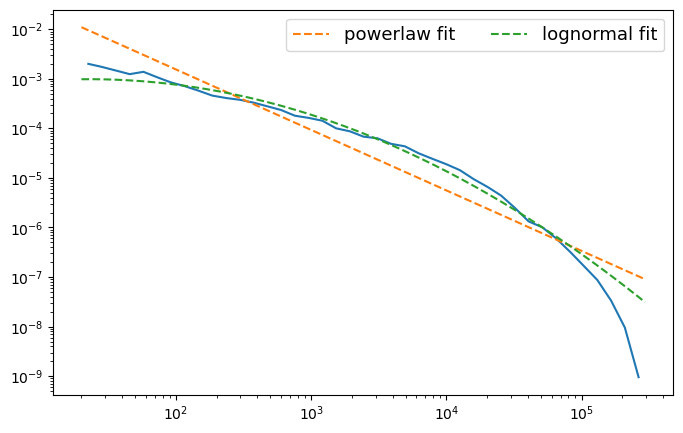

In [206]:
plt.figure(figsize=(8,5))

powerlaw.plot_pdf(flat_jump_length)

fit.power_law.plot_pdf(linestyle = '--', label='powerlaw fit')
# fit.truncated_power_law.plot_pdf(linestyle = '--', label='truncated power law')
fit.lognormal.plot_pdf(linestyle = '--', label='lognormal fit')

plt.legend(prop={'size': 13}, ncol=2)

plt.show()

# Language metrics

In [668]:
def bleu_score(recover, reference):
    return sentence_bleu(
        [reference],
        recover,
        smoothing_function=SmoothingFunction().method4,
    )

def get_scores(pred_ls, ref_ls):
    bleu_ls = []
    for pred, ref in zip(pred_ls, ref_ls):

        bleu_ls.append(bleu_score(pred, ref))
    return bleu_ls

def get_self_bleu(ls):
    selfBleu = []
    for i, seq in tqdm(enumerate(ls)):
        for j in range(i + 1, len(ls)):
            score = bleu_score(seq, ls[j])
            selfBleu.append(score)
    return np.mean(selfBleu)

def distinct_n_gram_inter_sent(hypn, n):
    hyp_ngrams = []
    for hyp in hypn:
        hyp_ngrams += nltk.ngrams(hyp, n)
    total_ngrams = len(hyp_ngrams)
    unique_ngrams = len(list(set(hyp_ngrams)))

    dist_n = unique_ngrams / total_ngrams
    return dist_n

def distinct_n_gram(hypn, n=1):
    dist_list = []
    for hyp in hypn:
        n1_grams = list(nltk.ngrams(hyp, n))
        dist_list.append(len(set(n1_grams))/len(n1_grams))
    return np.mean(dist_list)

## BLEU

In [669]:
predict_src_bleu = [get_scores(p, src_ls) for p in predict_ls]
predict_true_bleu = [get_scores(p, true_ls) for p in predict_ls]

In [670]:
true_src_bleu = get_scores(true_ls, src_ls)

In [671]:
print(f"Source and True: {np.average(true_src_bleu):.3f}")
for ps, pt, label in zip(predict_src_bleu, predict_true_bleu, diff_file_name):
    print(f"{label} and True: {np.average(pt):.3f}\t\t{label} and Source: {np.average(ps):.3f}")

Source and True: 0.077
Diffusion (Ours) and True: 0.242		Diffusion (Ours) and Source: 0.074


In [672]:
markov_true_bleu = get_scores(markov_ls, true_ls)
ar_true_bleu = get_scores(ar_ls, true_ls)
gan_true_bleu = get_scores(gan_ls, true_ls)

print(f"Markov and True: {np.average(markov_true_bleu):.3f}\nAR and True: {np.average(ar_true_bleu):.3f}\nGAN and True: {np.average(gan_true_bleu):.3f}")

Markov and True: 0.275
AR and True: 0.244
GAN and True: 0.002


In [673]:
epr_true_bleu = get_scores(epr_ls, true_ls)
container_true_bleu = get_scores(container_ls, true_ls)

print(f"EPR and True: {np.average(epr_true_bleu):.3f}\nContainer and True: {np.average(container_true_bleu):.3f}")

EPR and True: 0.087
Container and True: 0.187


## Self-bleu
Lower self-bleu suggests higher diversity

In [98]:
# slow
predict_bleu = get_self_bleu(predict_ls)
true_bleu = get_self_bleu(true_ls)
src_bleu = get_self_bleu(src_ls)

1it [00:05,  5.78s/it]


KeyboardInterrupt: 

## Diverse 4-gram
Higher div-4 suggests higher diversity

In [674]:
pred_div4 = [distinct_n_gram_inter_sent(p, 4) for p in predict_ls]
true_div4 = distinct_n_gram_inter_sent(true_ls, 4)
src_div4 = distinct_n_gram_inter_sent(src_ls, 4)

print(f"Source: {src_div4:.4f}\nTrue: {true_div4:.4f}")
for div, label in zip(pred_div4, diff_file_name):
    print(f"{label}: {div:.4f}")

Source: 0.0163
True: 0.0203
Diffusion (Ours): 0.4394


In [675]:
markov_div4 = distinct_n_gram_inter_sent(markov_ls, 4)
ar_div4 = distinct_n_gram_inter_sent(ar_ls, 4)
gan_div4 = distinct_n_gram_inter_sent(gan_ls, 4)

print(f"Markov: {markov_div4:.4f}\nAR: {ar_div4:.4f}\nGAN: {gan_div4:.4f}")

Markov: 0.0191
AR: 0.2941
GAN: 0.5973


In [676]:
epr_div4 = distinct_n_gram_inter_sent(epr_ls, 4)
container_div4 = distinct_n_gram_inter_sent(container_ls, 4)

print(f"EPR: {epr_div4:.4f}\nContainer: {container_div4:.4f}")

EPR: 0.7699
Container: 0.5744


## Distinct unigrams (1-gram)
intra-diversity within each sequence. Lower dist means more repeated tokens.

In [678]:
predict_1_gram = [distinct_n_gram(p) for p in predict_ls]
true_1_gram = distinct_n_gram(true_ls)
src_1_gram = distinct_n_gram(src_ls)

print(f"Source: {src_1_gram:.4f}\nTrue: {true_1_gram:.4f}")
for gram, label in zip(predict_1_gram, diff_file_name):
    print(f"{label}: {gram:.4f}")

Source: 0.1670
True: 0.2818
Diffusion (Ours): 0.2474


In [679]:
markov_1_gram = distinct_n_gram(markov_ls)
ar_1_gram = distinct_n_gram(ar_ls)
gan_1_gram = distinct_n_gram(gan_ls)

print(f"Markov: {markov_1_gram:.4f}\nAR: {ar_1_gram:.4f}\nGAN: {gan_1_gram:.4f}")

Markov: 0.0786
AR: 0.2073
GAN: 0.5106


In [680]:
epr_1_gram = distinct_n_gram(epr_ls)
container_1_gram = distinct_n_gram(container_ls)

print(f"EPR: {epr_1_gram:.4f}\nContainer: {container_1_gram:.4f}")

EPR: 0.4235
Container: 0.3084


# Entropy
## Real entropy

In [51]:
# na_layer6_14_200_1_200

def real_entropy_individual(locs_series):

    n = len(locs_series)

    # 1 to ensure to consider the first situation from where
    # locs_series[i:j] = [] and locs_series[i:j] = locs_series[0:1]
    sum_lambda = 1

    for i in range(1, n - 1):
        j = i + 1

        while True:
            # if the locs_series[i:j] is longer than locs_series[:i],
            # we can no longer find it locs_series[i:j] in locs_series[:i]
            if j - i > i:
                break

            # if locs_series[i:j] exist in locs_series[:i], we increase j by 1
            # sliding_window_view creates sublist of length len(locs_series[i:j]) from locs_series[:i]
            ls = np.lib.stride_tricks.sliding_window_view(locs_series[:i], j - i).tolist()
            if tuple(locs_series[i:j]) in list(map(tuple, ls)):
                # if the subsequence already exist, we increase the sequence by 1, and check again
                j += 1
            else:
                # we find the "shortest substring" that does not exist in locs_series[:i]
                break

        # length of the substring
        sum_lambda += j - i

    # the function S5 from the suppl. material
    return 1.0 / (sum_lambda * 1 / n) * np.log(n)



In [52]:
predict_re = [_apply_parallel(p, real_entropy_individual, n=-1) for p in predict_ls]

In [53]:
true_re = _apply_parallel(true_ls, real_entropy_individual, n=-1)
# source_re = _apply_parallel(src_ls, real_entropy_individual, n=-1)

In [54]:
markov_re = _apply_parallel(markov_ls, real_entropy_individual, n=-1)
ar_re = _apply_parallel(ar_ls, real_entropy_individual, n=-1)
gan_re = _apply_parallel(gan_ls, real_entropy_individual, n=-1)
epr_re = _apply_parallel(epr_ls, real_entropy_individual, n=-1)

container_re = _apply_parallel(container_ls, real_entropy_individual, n=-1)

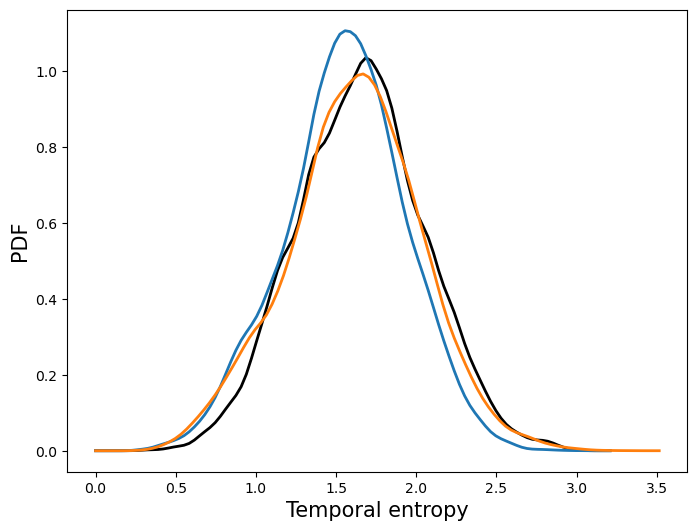

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

density = stats.gaussian_kde(true_re)
x = np.linspace(0, np.max(true_re) + 0.2, 100)
ax.plot(x, density(x), label="Data", color="k", linewidth=2)

# density = stats.gaussian_kde(source_re)
# x = np.linspace(0, np.max(source_re) + 0.2, 100)
# ax.plot(x, density(x), label="source")

for pre, label in zip(predict_re, diff_file_name):
    density = stats.gaussian_kde(pre)
    x = np.linspace(0, np.max(pre) + 0.2, 100)
    # ax.plot(x, density(x), color="tomato", linewidth=2, label=label)
    ax.plot(x, density(x), linewidth=2, label=label)

# density = stats.gaussian_kde(markov_re)
# x = np.linspace(0, np.max(markov_re) + 0.2, 100)
# ax.plot(x, density(x), color=colors[4], label="Markov", linewidth=1.5, alpha=0.7)

# density = stats.gaussian_kde(ar_re)
# x = np.linspace(0, np.max(ar_re) + 0.2, 100)
# ax.plot(x, density(x), color=colors[5], label="MHSA", linewidth=1.5, alpha=0.7)

# density = stats.gaussian_kde(gan_re)
# x = np.linspace(0, np.max(gan_re) + 0.2, 100)
# ax.plot(x, density(x), color=colors[6], label="MovSim", linewidth=1.5, alpha=0.7)

# density = stats.gaussian_kde(epr_re)
# x = np.linspace(0, np.max(epr_re) + 0.2, 100)
# ax.plot(x, density(x), label="EPR", color=colors[0], linewidth=1.5, alpha=0.7)

# density = stats.gaussian_kde(container_re)
# x = np.linspace(0, np.max(container_re) + 0.2, 100)
# ax.plot(x, density(x), label="Container", color=colors[2], linewidth=1.5, alpha=0.7,)

# plt.legend(prop={"size": 12}, frameon=False, bbox_to_anchor=(-0.5, -0.2), loc="upper left", bbox_transform=fig.transFigure, ncol=7)
plt.xlabel("Temporal entropy", fontsize=15)
plt.ylabel("PDF", fontsize=15)
# plt.xlim([0, 4.1])

# plt.savefig(r'.\metrics\figures\entropy_tem_all.png', bbox_inches='tight', dpi=600)
plt.show()

In [927]:
predict_density = stats.gaussian_kde(predict_re)
true_density = stats.gaussian_kde(true_re)
source_density = stats.gaussian_kde(source_re)

markov_density = stats.gaussian_kde(markov_re)
ar_density = stats.gaussian_kde(ar_re)
gan_density = stats.gaussian_kde(gan_re)

epr_density = stats.gaussian_kde(epr_re)
container_density = stats.gaussian_kde(container_re)

In [1265]:
x = np.linspace(0, 3, 1000)

pred_true_re = distance.jensenshannon(predict_density(x), true_density(x))
source_true_re = distance.jensenshannon(source_density(x), true_density(x))

print(f"Prediction and True: {pred_true_re:.3f}\t Source and True: {source_true_re:.3f}")

Prediction and True: 0.268	 Source and True: 0.084


In [1266]:
markov_true_re = distance.jensenshannon(markov_density(x), true_density(x))
ar_true_re = distance.jensenshannon(ar_density(x), true_density(x))
gan_true_re = distance.jensenshannon(gan_density(x), true_density(x))

print(f"Markov and True: {markov_true_re:.3f}\t AR and True: {ar_true_re:.3f}\t GAN and True: {gan_true_re:.3f}")

Markov and True: 0.653	 AR and True: 0.253	 GAN and True: 0.449


In [1267]:
epr_true_re = distance.jensenshannon(epr_density(x), true_density(x))
container_true_re = distance.jensenshannon(container_density(x), true_density(x))

print(f"EPR and True: {epr_true_re:.3f}\t Container and True: {container_true_re:.3f}")

EPR and True: 0.419	 Container and True: 0.155


In [1271]:
for predict_variantions in predict_re:
    print(wasserstein_distance(predict_variantions, true_re))

0.10287483026181526
0.0680357152664238
0.238435236047317
0.14015643142726275
0.14310730429521154
0.1104489265799664


In [333]:
wasserstein_distance(predict_re[0], true_re),\
wasserstein_distance(markov_re, true_re),\
wasserstein_distance(ar_re, true_re),\
wasserstein_distance(gan_re, true_re),\
wasserstein_distance(epr_re, true_re),\
wasserstein_distance(container_re, true_re)

(0.04546086529578332,
 0.7272621381821822,
 0.3000547380266365,
 0.5055258298102989,
 0.5393998789668848,
 0.17956715481229105)

### Loglikelihood

In [334]:
predict_lk = predict_density.logpdf(true_re)
markov_lk = markov_density.logpdf(true_re)
ar_lk = ar_density.logpdf(true_re)
gan_lk = gan_density.logpdf(true_re)
epr_lk = epr_density.logpdf(true_re)
container_lk = container_density.logpdf(true_re)

In [335]:
loglikelihood_ratio(predict_lk, markov_lk),\
loglikelihood_ratio(predict_lk, ar_lk),\
loglikelihood_ratio(predict_lk, gan_lk),\
loglikelihood_ratio(predict_lk, epr_lk),\
loglikelihood_ratio(predict_lk, container_lk)

((2728469.556987768, 0.0),
 (9436.518302806573, 0.0),
 (22657.803092305563, 0.0),
 (30119.127913990982, 0.0),
 (3370.303449857369, 3.2569846892900786e-213))

## Uncorrelated entropy

In [56]:
def uncorrelated_entropy_individual(locs_series):
    _, counts = np.unique(locs_series, return_counts=True)
    freq = counts/len(locs_series)
    return -(freq * np.log(freq)).sum()


In [57]:
predict_ue = [[uncorrelated_entropy_individual(seq) for seq in p] for p in predict_ls]

In [58]:
true_ue = [uncorrelated_entropy_individual(seq) for seq in true_ls]
source_ue = [uncorrelated_entropy_individual(seq) for seq in src_ls]

In [59]:
markov_ue = [uncorrelated_entropy_individual(seq) for seq in markov_ls]
ar_ue = [uncorrelated_entropy_individual(seq) for seq in ar_ls]
gan_ue = [uncorrelated_entropy_individual(seq) for seq in gan_ls]
epr_ue = [uncorrelated_entropy_individual(seq) for seq in epr_ls]
container_ue = [uncorrelated_entropy_individual(seq) for seq in container_ls]

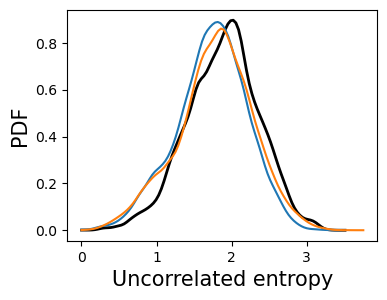

In [60]:
# na_layer6_14_200_1_200

fig, ax = plt.subplots(1, 1, figsize=(4, 3))

density = stats.gaussian_kde(true_ue)
x = np.linspace(0, np.max(true_ue) + 0.2, 100)
ax.plot(x, density(x), label="Data", color="k", linewidth=2)

# density = stats.gaussian_kde(source_ue)
# x = np.linspace(0, np.max(source_ue) + 0.2, 100)
# ax.plot(x, density(x), label="source")

for pre, label in zip(predict_ue, diff_file_name):
    density = stats.gaussian_kde(pre)
    x = np.linspace(0, np.max(pre) + 0.2, 100)
    # ax.plot(x, density(x), color="tomato", linewidth=2, label=label)
    ax.plot(x, density(x), label=label)

# density = stats.gaussian_kde(markov_ue)
# x = np.linspace(0, np.max(markov_ue) + 0.2, 100)
# ax.plot(x, density(x), label="Markov", color=colors[4], linewidth=1.5, alpha=0.7)

# density = stats.gaussian_kde(ar_ue)
# x = np.linspace(0, np.max(ar_ue) + 0.2, 100)
# ax.plot(x, density(x), label="MHSA", color=colors[5], linewidth=1.5, alpha=0.7)

# density = stats.gaussian_kde(gan_ue)
# x = np.linspace(0, np.max(gan_ue) + 0.2, 100)
# ax.plot(x, density(x), label="MovSim", color=colors[6], linewidth=1.5, alpha=0.7)

# density = stats.gaussian_kde(epr_ue)
# x = np.linspace(0, np.max(epr_ue) + 0.2, 100)
# ax.plot(x, density(x), label="EPR", color=colors[0], linewidth=1.5, alpha=0.7)

# density = stats.gaussian_kde(container_ue)
# x = np.linspace(0, np.max(container_ue) + 0.2, 100)
# ax.plot(x, density(x), label="Container", color=colors[2], linewidth=1.5, alpha=0.7)


# plt.legend(prop={"size": 10})
plt.xlabel("Uncorrelated entropy", fontsize=15)
plt.ylabel("PDF", fontsize=15)

# plt.legend(prop={"size": 12}, frameon=False, bbox_to_anchor=(-0.5, -0.2), loc="upper left", bbox_transform=fig.transFigure, ncol=4)

# plt.savefig(r'.\metrics\figures\entropy_unc.png', bbox_inches='tight', dpi=600)
plt.show()


In [1164]:
predict_density = stats.gaussian_kde(predict_ue)
true_density = stats.gaussian_kde(true_ue)
source_density = stats.gaussian_kde(source_ue)

markov_density = stats.gaussian_kde(markov_ue)
ar_density = stats.gaussian_kde(ar_ue)
gan_density = stats.gaussian_kde(gan_ue)
epr_density = stats.gaussian_kde(epr_ue)
container_density = stats.gaussian_kde(container_ue)

In [1165]:
x = np.linspace(0, 3, 1000)

pred_true_ue = distance.jensenshannon(predict_density(x), true_density(x))
source_true_ue = distance.jensenshannon(source_density(x), true_density(x))

markov_true_ue = distance.jensenshannon(markov_density(x), true_density(x))
ar_true_ue = distance.jensenshannon(ar_density(x), true_density(x))
gan_true_ue = distance.jensenshannon(gan_density(x), true_density(x))

epr_true_ue = distance.jensenshannon(epr_density(x), true_density(x))
container_true_ue = distance.jensenshannon(container_density(x), true_density(x))


print(f"Prediction and True: {pred_true_ue:.3f}\t Source and True: {source_true_ue:.3f}")
print(f"Markov and True: {markov_true_ue:.3f}\t AR and True: {ar_true_ue:.3f}\t GAN and True: {gan_true_ue:.3f}")
print(f"EPR and True: {epr_true_ue:.3f}\t Container and True: {container_true_ue:.3f}")

Prediction and True: 0.268	 Source and True: 0.084
Markov and True: 0.653	 AR and True: 0.253	 GAN and True: 0.449
EPR and True: 0.419	 Container and True: 0.155


### Wasserstein distance

In [1272]:
for predict_variantions in predict_ue:
    print(wasserstein_distance(predict_variantions, true_ue))

0.4186636581023034
0.29297602102754267
0.2948706814758056
0.25196185593141507


In [568]:
wasserstein_distance(predict_ue[0], true_ue),\
wasserstein_distance(markov_ue, true_ue),\
wasserstein_distance(ar_ue, true_ue),\
wasserstein_distance(gan_ue, true_ue),\
wasserstein_distance(epr_ue, true_ue),\
wasserstein_distance(container_ue, true_ue)

(0.15527611294335006,
 0.9115530925359466,
 0.3494886810970351,
 0.9244147369442521,
 0.5970015955254161,
 0.20415402784330056)

### Loglikelihood

In [571]:
predict_lk = predict_density.logpdf(true_ue)
markov_lk = markov_density.logpdf(true_ue)
ar_lk = ar_density.logpdf(true_ue)
gan_lk = gan_density.logpdf(true_ue)
epr_lk = epr_density.logpdf(true_ue)
container_lk = container_density.logpdf(true_ue)

In [572]:
loglikelihood_ratio(predict_lk, markov_lk),\
loglikelihood_ratio(predict_lk, ar_lk),\
loglikelihood_ratio(predict_lk, gan_lk),\
loglikelihood_ratio(predict_lk, epr_lk),\
loglikelihood_ratio(predict_lk, container_lk)

((328042.901699942, 0.0),
 (6921.002540604997, 0.0),
 (47404.112614605685, 0.0),
 (73277.1520670844, 0.0),
 (1307.0503065684222, 1.5437465589427424e-19))

## Difference between real and uncorrelated

In [172]:
pred_diff = [[re - ue for re, ue in zip(r,u)] for r,u in zip(predict_re, predict_ue)]

In [173]:
true_diff = [re - ue for re, ue in zip(true_re,true_ue)]
# source_diff = [re - ue for re, ue in zip(source_re,source_ue)]

In [174]:
markov_diff = [re - ue for re, ue in zip(markov_re,markov_ue)]
ar_diff = [re - ue for re, ue in zip(ar_re,ar_ue)]
gan_diff = [re - ue for re, ue in zip(gan_re,gan_ue)]
epr_diff = [re - ue for re, ue in zip(epr_re, epr_ue)]
container_diff = [re - ue for re, ue in zip(container_re, container_ue)]

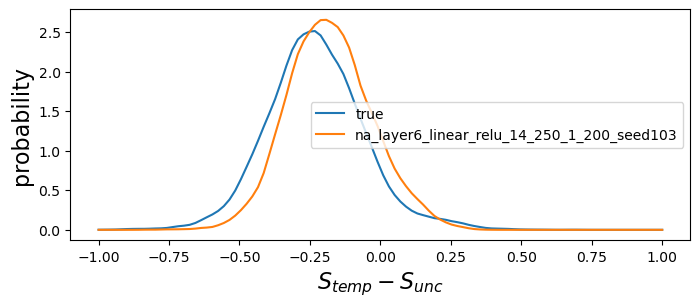

In [175]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))

x = np.linspace(-1, 1, 100)

density = stats.gaussian_kde(true_diff)
ax.plot(x, density(x), label="true")

# density = stats.gaussian_kde(source_diff)
# x = np.linspace(-1, 1, 100)
# ax.plot(x, density(x), label="source")

for pre, label in zip(pred_diff, diff_file_name):
    density = stats.gaussian_kde(pre)
    ax.plot(x, density(x), label=label)

# density = stats.gaussian_kde(ar_diff)
# ax.plot(x, density(x), label="MHSA (ours)")

# density = stats.gaussian_kde(markov_diff)
# ax.plot(x, density(x), label="Markov", alpha=0.5)

# density = stats.gaussian_kde(gan_diff)
# ax.plot(x, density(x), label="MovSim", alpha=0.5)

# density = stats.gaussian_kde(epr_diff)
# ax.plot(x, density(x), label="EPR", alpha=0.5)

# density = stats.gaussian_kde(container_diff)
# ax.plot(x, density(x), label="Container", alpha=0.5)

plt.legend(prop={"size": 10})
plt.xlabel("$S_{temp} - S_{unc}$", fontsize=16)
plt.ylabel("probability", fontsize=16)

# plt.savefig(r'.\metrics\figures\ent_diff.png', bbox_inches='tight', dpi=600)
plt.show()

In [72]:
predict_density = stats.gaussian_kde(pred_diff[0])
true_density = stats.gaussian_kde(true_diff)
source_density = stats.gaussian_kde(source_diff)

x = np.linspace(-1, 1, 1000)

pred_true_diff = distance.jensenshannon(predict_density(x), true_density(x))
source_true_diff = distance.jensenshannon(source_density(x), true_density(x))

print(f"Prediction and True: {pred_true_diff:.3f}\t Source and True: {source_true_diff:.3f}")

NameError: name 'source_diff' is not defined

In [254]:
markov_density = stats.gaussian_kde(markov_diff)
markov_true_diff = distance.jensenshannon(markov_density(x), true_density(x))

ar_density = stats.gaussian_kde(ar_diff)
ar_true_diff = distance.jensenshannon(ar_density(x), true_density(x))

gan_density = stats.gaussian_kde(gan_diff)
gan_true_diff = distance.jensenshannon(gan_density(x), true_density(x))

print(f"Markov and True: {markov_true_diff:.3f}\t AR and True: {ar_true_diff:.3f}\t GAN and True: {gan_true_diff:.3f}")

Markov and True: 0.340	 AR and True: 0.141	 GAN and True: 0.717


In [255]:
epr_density = stats.gaussian_kde(epr_diff)
epr_true_diff = distance.jensenshannon(epr_density(x), true_density(x))

print(f"EPR and True: {epr_true_diff:.3f}")

EPR and True: 0.389


### Log-likelihood Ratio

In [327]:
predict_lk = predict_density.logpdf(true_diff)
epr_lk = epr_density.logpdf(true_diff)

In [335]:
markov_lk = markov_density.logpdf(true_diff)
ar_lk = ar_density.logpdf(true_diff)

In [338]:
loglikelihood_ratio(predict_lk, markov_lk)

(-45057.917133547104, 8.342522715116849e-282)

In [339]:
loglikelihood_ratio(predict_lk, ar_lk)

(-59612.19948867087, 0.0)

In [340]:
loglikelihood_ratio(markov_lk, ar_lk)

(-14554.282355123138, 0.0)

In [329]:
R

104632.93332755628